In [1]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

np.random.seed(42)

data_dir = "data/framing_politicians/morals/"

In [2]:
%run frame_axis.py
# Loads FrameAxis class
help(FramePole)

Help on class FramePole in module __main__:

class FramePole(builtins.object)
 |  FramePole(pole_name, words, model)
 |  
 |  Represents a pole of the FrameAxis. Thus either positive or negative words.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, pole_name, words, model)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  compute(self)
 |      Computes everything for its usage (e.g., centroid).
 |  
 |  compute_centroid(self)
 |      Computes the centroid and vectors. Assumes valid vocabulary. Call `retain_model_words_only` beforehand.
 |  
 |  extract_vectors_from_model(self)
 |      Extract the relevant vectors from the model. In same order as the words.
 |  
 |  retain_model_words_only(self, log_removed=False)
 |      Cleans the initial words to fit the supplied model.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if 

In [3]:
dict_df = pd.read_csv(data_dir + "mfd2.0.dic", sep="\t", skiprows=12, header=None, names=["word", "moral_id"])
dict_df

,word,moral_id
0,compassion,1
1,empathy,1
2,kindness,1
3,caring,1
4,generosity,1
...,...,...
2099,cum,10
2100,divorcing,10
2101,wasted,10
2102,divorced,10


In [4]:
moral_ids_df = pd.read_csv(data_dir + "mfd2.0.dic", sep="\t", skiprows=1, nrows=10, header=None, index_col=0, names=["moral_id", "moral_name"])
# dict(moral_ids_df)
moral_mapping = moral_ids_df["moral_name"].to_dict()
moral_mapping

{1: 'care.virtue',
 2: 'care.vice',
 3: 'fairness.virtue',
 4: 'fairness.vice',
 5: 'loyalty.virtue',
 6: 'loyalty.vice',
 7: 'authority.virtue',
 8: 'authority.vice',
 9: 'sanctity.virtue',
 10: 'sanctity.vice'}

In [5]:
dict_df["moral"] = dict_df["moral_id"].map(moral_mapping)
dict_df

,word,moral_id,moral
0,compassion,1,care.virtue
1,empathy,1,care.virtue
2,kindness,1,care.virtue
3,caring,1,care.virtue
4,generosity,1,care.virtue
...,...,...,...
2099,cum,10,sanctity.vice
2100,divorcing,10,sanctity.vice
2101,wasted,10,sanctity.vice
2102,divorced,10,sanctity.vice


In [6]:
word_dict = dict_df.set_index("word")["moral"].to_dict()

We now want to analyze where the virtues and vices lie within pretrained word2vec models.
Some approaches, like FrameAxis might rely on certain properties of the word embeddings.
This will give us first insights whether the approach is suitable and how we can improve upon it.

In [7]:
care = dict_df[dict_df["moral"] == "care.virtue"]["word"].values
harm = dict_df[dict_df["moral"] == "care.vice"]["word"].values
other_morals = dict_df[(dict_df["moral"] != "care.virtue") & (dict_df["moral"] != "care.vice")]["word"].values
print(len(care))
print(len(harm))
print(len(other_morals))
care[:5]

182
288
1634


array(['compassion', 'empathy', 'kindness', 'caring', 'generosity'],
      dtype=object)

In [8]:
# Real model from: load glove.840B.300d.zip from https://nlp.stanford.edu/projects/glove/
# import wget
# wget.download("http://nlp.stanford.edu/data/glove.840B.300d.zip")

In [9]:
model = KeyedVectors.load_word2vec_format('glove.840B.300d.txt', binary=False, no_header=True, limit=50_000)  # Requires Gensim >= 4.0 for no_header of GloVe format

In [10]:
fp_care = FramePole("care", care, model)
print(len(fp_care.words))
fp_care.retain_model_words_only(False)
print(len(fp_care.words))
fp_care.retain_model_words_only(True)  # shouldn't change anything
print(len(fp_care.words))
fp_care.compute_centroid()[:10]

182
117
117
117


array([-0.09482064,  0.04027167, -0.17508838,  0.13379993, -0.16902246,
       -0.2010239 , -0.01671241, -0.05244965,  0.04797183,  1.9752499 ],
      dtype=float32)

In [11]:
fp_harm = FramePole("harm", harm, model)
print(len(fp_harm.words))
fp_harm.retain_model_words_only(False)
fp_harm.compute_centroid()[:10]

288
149


array([-0.4739534 ,  0.04266785, -0.10068792,  0.08481868, -0.09783615,
       -0.26859328, -0.04369458,  0.22398712, -0.16304573,  1.9900912 ],
      dtype=float32)

In [12]:
fp_other = FramePole("other", other_morals, model)
print(len(fp_other.words))
fp_other.retain_model_words_only(False)
fp_other.compute_centroid()[:10]

1634
771


array([-0.19545285, -0.1372247 ,  0.03625942, -0.02735737, -0.06511963,
       -0.0578699 ,  0.07220072,  0.11663801, -0.06005505,  1.7498043 ],
      dtype=float32)

# Time to Visualize

1037
             x         y  labels
0     1.971744 -0.934061   False
1     0.290972 -0.661681    True
2     1.983959 -0.710608   False
3     0.073218 -0.947684    True
4     1.307936 -1.733748    True
...        ...       ...     ...
1032 -0.108094  1.758074   False
1033  0.018359  2.220139   False
1034 -0.815775  1.117731   False
1035  0.773797  0.490296   False
1036 -0.879459  0.215135    True

[1037 rows x 3 columns]


[(-4.0, 4.0), (-4.0, 4.0)]

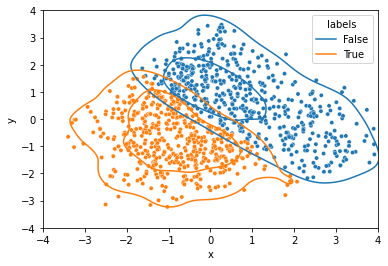

In [13]:
# Fit TSNE beforehand on all, and just plot transformed space.
all_morals = dict_df["word"].values
fp_all = FramePole("all", all_morals, model)  # Abusing frame pole here, since it converts words to vectors
fp_all.retain_model_words_only(False)
fp_all.compute_centroid()

# fitted_reducer = umap.UMAP(n_components=2, n_neighbors=3, min_dist=0.3).fit(fp_all.pole_vecs)
fitted_reducer = PCA(n_components=2).fit(fp_all.pole_vecs)

# Plot transformed space
projection = fitted_reducer.transform(fp_all.pole_vecs)
x = projection[:,0]
y = projection[:,1]

# sample_labels = pd.Series(["a"]*500 + ["b"]*(len(projection)-500), name="labels")
plot_df = pd.DataFrame(projection, columns=["x", "y"])
plot_df["labels"] = plot_df["x"] + plot_df["y"] < 0
# plot_df = pd.concat([plot_df, sample_labels], axis=1)
# plot_df["labels"], _ = pd.factorize(plot_df["labels"])
print(plot_df)
# sns.scatterplot(x=x, y=y, size=[1]*len(x), legend=False)
ax = sns.scatterplot(data=plot_df, x="x", y="y", hue="labels", size=[1]*len(x), )
sns.kdeplot(data=plot_df, x="x", y="y", hue="labels", levels=3)#, palette=sns.color_palette(), fill=True)#, legend=False)#,? hue=)#, )
ax.set(xlim=(-4,4), ylim=(-4,4))
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels)

## Scatterplots per Axis

In [14]:
tsne = manifold.TSNE(n_components=2)
# maybe dont fit centroids, just transform them, but tsne model does not seem to support that...
projection = tsne.fit_transform(fp_care.pole_vecs + fp_harm.pole_vecs + fp_other.pole_vecs + [fp_care.centroid] + [fp_harm.centroid])
print(projection.shape)
projection[:10]

(1039, 2)


array([[ -6.4792595 ,  25.83918   ],
       [ -5.681346  ,  26.180525  ],
       [ -7.315774  ,  25.725435  ],
       [-16.36329   ,   2.405654  ],
       [ -7.9590597 ,  25.914402  ],
       [-23.507095  ,   8.676458  ],
       [-15.075152  ,   4.6432037 ],
       [ -7.213147  ,  28.280872  ],
       [-15.498948  ,   4.440069  ],
       [-16.62337   ,  -0.48614323]], dtype=float32)

In [15]:
labels =  ["care"]*len(fp_care.pole_vecs) + ["harm"]*len(fp_harm.pole_vecs) + ["other_morals"]*len(fp_other.pole_vecs) + ["care_centroid"] + ["harm_centroid"]
len(labels)

1039

In [16]:
x1, y1 = projection[-2]
x2, y2 = projection[-1]
print(x1,y1,x2,y2)

dx, dy = x1 - x2, y1 -y2
print(dx,dy)

-11.516064 3.6844375 14.416365 -6.5746274
-25.932428 10.259065


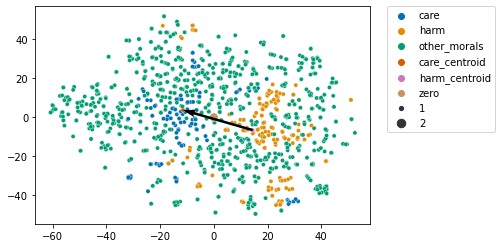

In [17]:
# add the zero point
x = np.append(projection[:,0], [0])
y = np.append(projection[:,1], [0])
hue = labels + ["zero"]

sns.scatterplot(x=x, y=y, hue=hue, palette="colorblind", size=[1]*len(projection) + [2])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.arrow(x1,y2,dx,dy, width=1, length_includes_head=True)
ax = plt.gca()
# ax.annotate("", xy=(x1,y2), xytext=(x2,y2), xycoords="data", textcoords="data", arrowprops=dict(arrowstyle="->"),)
plt.quiver(x2, y2, dx, dy, angles='xy', scale_units='xy', scale=1)

In [18]:
def visualize_frame_axis(pos_pole, neg_pole, oth_pole, model, reducer=None, add_kde=True, lim=4.2, use_legend=False):
    if reducer is None:
        # Use reduced define outside
        reducer = fitted_reducer
    
    title = pos_pole.pole_name.capitalize() + "/" + neg_pole.pole_name.capitalize()
    pos_words = pos_pole.words
    neg_words = neg_pole.words
    oth_words = oth_pole.words

    pos_centroid = pos_pole.centroid
    pos_vecs = pos_pole.pole_vecs
    neg_centroid = neg_pole.centroid
    neg_vecs = neg_pole.pole_vecs
    oth_centroid = oth_pole.centroid
    oth_vecs = oth_pole.pole_vecs

    projection = reducer.transform(pos_vecs + neg_vecs + oth_vecs + [pos_centroid] + [neg_centroid])
    print(projection.shape)
    
    labels =  ["virtues"]*len(pos_vecs) + ["vices"]*len(neg_vecs) + ["other"]*len(oth_vecs) + ["pos_centroid"] + ["neg_centroid"]
    
    x1, y1 = projection[-2]
    x2, y2 = projection[-1]

    dx, dy = x1 - x2, y1 -y2

    x = projection[:-2,0]
    y = projection[:-2,1]
    labels = labels[:-2]  # ignore centroids
    
    plot_df = pd.DataFrame(projection[:-2,:], columns=["x", "y"])
    plot_df = pd.concat([plot_df, pd.Series(labels, name="labels")], axis=1)

    ax = sns.scatterplot(data=plot_df, x="x", y="y", hue="labels", style="labels", palette="colorblind", legend=use_legend, size=[1]*len(x))
    if add_kde:
        sns.kdeplot(data=plot_df[plot_df["labels"] != "other"], x="x", y="y", hue="labels", legend=use_legend, levels=3, thresh=.33)
    if use_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[:-1], labels=labels[:-1])
    
    ax = plt.gca()
    ax.set(xlim=(-lim, lim), ylim=(-lim, lim))
    plt.quiver(x2, y2, dx, dy, angles='xy', scale_units='xy', scale=1)
    
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    sns.despine()

(1039, 2)


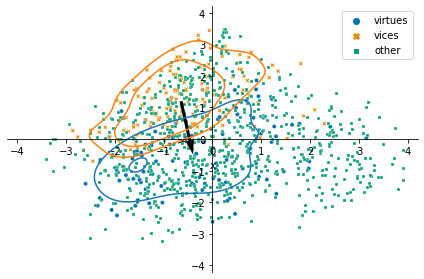

In [19]:
visualize_frame_axis(fp_care, fp_harm, fp_other, model, use_legend=True)

plt.tight_layout()
plt.savefig("plots/care_with_legend.pdf", dpi=300)

(1039, 2)


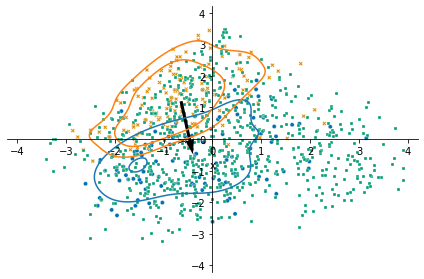

In [20]:
visualize_frame_axis(fp_care, fp_harm, fp_other, model)

plt.tight_layout()
plt.savefig("plots/care.pdf", dpi=300)

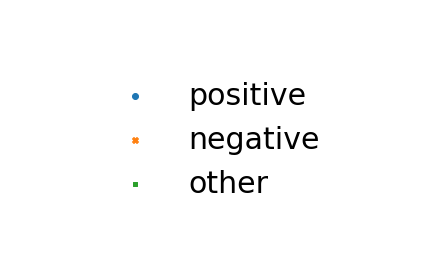

In [21]:
# Plot legend only
labels = ["positive", "negative", "other"]
ax = sns.scatterplot(x=[0,1,2], y=[0,1,2], hue=labels, style=labels, cmap=sns.color_palette())
h,l = ax.get_legend_handles_labels()
ax.legend_.remove()
plt.close()

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(h, l, loc="center", bbox_to_anchor=(0.5, 0.5), frameon=False, prop={'size': 30})

figl.tight_layout()
plt.savefig("plots/legend.pdf", dpi=300)

56
80
901
(1039, 2)


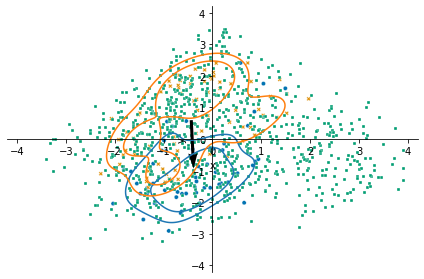

In [22]:
fairness = dict_df[dict_df["moral"] == "fairness.virtue"]["word"].values
cheating = dict_df[dict_df["moral"] == "fairness.vice"]["word"].values
non_fairness = dict_df[(dict_df["moral"] != "fairness.virtue") & (dict_df["moral"] != "fairness.vice")]["word"].values

fp_fair = FramePole("Fairness", fairness, model).compute()
fp_chea = FramePole("Cheating", cheating, model).compute()
fp_non_fair = FramePole("Non Fairness", non_fairness, model).compute()

visualize_frame_axis(fp_fair, fp_chea, fp_non_fair, model)

plt.tight_layout()
plt.savefig("plots/fairness.pdf", dpi=300)

98
14
925
(1039, 2)


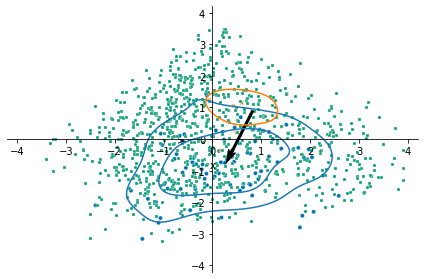

In [23]:
loyalty = dict_df[dict_df["moral"] == "loyalty.virtue"]["word"].values
betrayal = dict_df[dict_df["moral"] == "loyalty.vice"]["word"].values
non_loyalty = dict_df[(dict_df["moral"] != "loyalty.virtue") & (dict_df["moral"] != "loyalty.vice")]["word"].values

fp_loya = FramePole("Loyalty", loyalty, model).compute()
fp_betr = FramePole("Betrayal", betrayal, model).compute()
fp_non_loyal = FramePole("Non Loyalty", non_loyalty, model).compute()

visualize_frame_axis(fp_loya, fp_betr, fp_non_loyal, model)

plt.tight_layout()
plt.savefig("plots/loyalty.pdf", dpi=300)

180
32
825
(1039, 2)


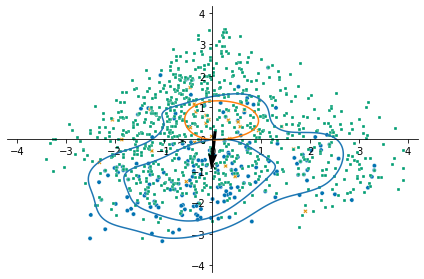

In [24]:
authority = dict_df[dict_df["moral"] == "authority.virtue"]["word"].values
subversion = dict_df[dict_df["moral"] == "authority.vice"]["word"].values
non_authority = dict_df[(dict_df["moral"] != "authority.virtue") & (dict_df["moral"] != "authority.vice")]["word"].values

fp_auth = FramePole("Authority", authority, model).compute()
fp_subv = FramePole("Subversion", subversion, model).compute()
fp_non_auth = FramePole("Non Authority", non_authority, model).compute()

visualize_frame_axis(fp_auth, fp_subv, fp_non_auth, model)

plt.tight_layout()
plt.savefig("plots/authority.pdf", dpi=300)

148
163
726
(1039, 2)


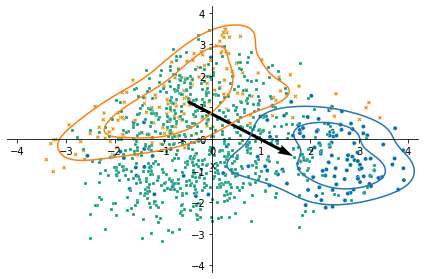

In [25]:
sanctity = dict_df[dict_df["moral"] == "sanctity.virtue"]["word"].values
degradation = dict_df[dict_df["moral"] == "sanctity.vice"]["word"].values
non_sanctity = dict_df[(dict_df["moral"] != "sanctity.virtue") & (dict_df["moral"] != "sanctity.vice")]["word"].values

fp_sanc = FramePole("Sanctity", sanctity, model).compute()
fp_degr = FramePole("Degradation", degradation, model).compute()
fp_non_sanc = FramePole("Non Sanctity", non_sanctity, model).compute()

visualize_frame_axis(fp_sanc, fp_degr, fp_non_sanc, model)

plt.tight_layout()
plt.savefig("plots/sanctity.pdf", dpi=300)

## Orientation of Axes

In [30]:
frame_poles = [
    (fp_care, fp_harm),
    (fp_fair, fp_chea),
    (fp_loya, fp_betr),
    (fp_auth, fp_subv),
    (fp_sanc, fp_degr),
]

In [31]:
frame_vectors = [pos.centroid - neg.centroid for pos, neg in frame_poles]

In [32]:
frame_axis = ["care", "fairness", "loyalty", "authority", "sanctity"]
np.array(frame_vectors).shape

(5, 300)

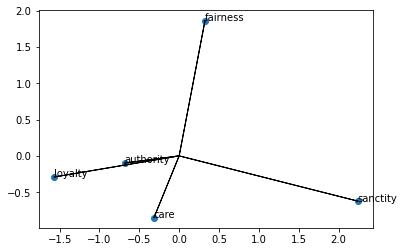

In [33]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(frame_vectors)
t = reduced.transpose()
plt.scatter(t[0], t[1])

# draw lines from center
for x, y in zip(t[0], t[1]):
    plt.arrow(0, 0, x, y)
    
# print names on points
ax = plt.gca()
for i, name in enumerate(frame_axis):
    ax.annotate(name, (t[0,i], t[1,i]))

# Polarization of Poles

In [34]:
for pos_pole, neg_pole in frame_poles:
    frame_axis = FrameAxis.from_poles(pos_pole, neg_pole).compute()
    print(pos_pole.pole_name, neg_pole.pole_name)
    print(frame_axis_polarization(frame_axis))

care harm
inter_dist_pos=0.49928313 inter_dist_neg=0.44957027 between_dist_pos=0.62066644 between_dist_neg=0.65581906
0.16381603479385376
Fairness Cheating
inter_dist_pos=0.46973196 inter_dist_neg=0.45338902 between_dist_pos=0.6129273 between_dist_neg=0.62098265
0.15539449453353882
Loyalty Betrayal
inter_dist_pos=0.50008285 inter_dist_neg=0.3464062 between_dist_pos=0.5506483 between_dist_neg=0.65816396
0.18116158246994019
Authority Subversion
inter_dist_pos=0.530202 inter_dist_neg=0.45337534 between_dist_pos=0.5969045 between_dist_neg=0.65847075
0.13589897751808167
Sanctity Degradation
inter_dist_pos=0.47426853 inter_dist_neg=0.5052312 between_dist_pos=0.69403696 between_dist_neg=0.6733769
0.19395709037780762
